## 1. Import required Libraries

In [30]:
# <<insert yout code here>>
import os 
import numpy as np
import tensorflow as tf

from collections import Counter
from sklearn.model_selection import KFold, train_test_split
from cleanlab.filter import find_label_issues
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout, GlobalAveragePooling2D, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pyplot as plt

## 2. Loading the Data

In [31]:
# <<insert yout code here>>
image_dir = './Images'

labels = []
data = []

allowed_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
img_size = (150, 150)   

for label in os.listdir(image_dir):
    subfolder_path = os.path.join(image_dir, label)

    if os.path.isdir(subfolder_path):
        for image_file in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_file)

            if any(image_file.lower().endswith(ext) for ext in allowed_extensions):
                try: 
                    image = load_img(image_path, color_mode='rgb', target_size=img_size)
                    image = np.array(image) / 255.0

                    labels.append(int(label[-1]) -1)
                    data.append(image)
                
                except Exception as e:
                    print(f"Error loading image {image_path}: {e}")


X_all = np.array(data)
y_all = np.array(labels)


print("Loaded images:", X_all.shape)
print("Loaded labels:", y_all.shape)
print("First 5 images in X_all:\n", X_all[:5])
print("First 5 labels in y_all:\n", y_all[:5])

Loaded images: (8538, 150, 150, 3)
Loaded labels: (8538,)
First 5 images in X_all:
 [[[[0.46666667 0.38431373 0.27058824]
   [0.49019608 0.40784314 0.29411765]
   [0.49019608 0.40784314 0.30196078]
   ...
   [0.58823529 0.57647059 0.55686275]
   [0.58431373 0.57254902 0.55294118]
   [0.58039216 0.56862745 0.54901961]]

  [[0.46666667 0.38431373 0.27058824]
   [0.48235294 0.4        0.28627451]
   [0.49019608 0.40784314 0.30196078]
   ...
   [0.58823529 0.57647059 0.55686275]
   [0.58431373 0.57254902 0.55294118]
   [0.58039216 0.56862745 0.54901961]]

  [[0.45490196 0.37254902 0.26666667]
   [0.46666667 0.38431373 0.27843137]
   [0.47843137 0.39607843 0.29019608]
   ...
   [0.58039216 0.56862745 0.54901961]
   [0.57254902 0.56078431 0.54117647]
   [0.56862745 0.55686275 0.5372549 ]]

  ...

  [[0.66666667 0.6627451  0.64313725]
   [0.67058824 0.66666667 0.64705882]
   [0.6745098  0.67058824 0.65098039]
   ...
   [0.70980392 0.71372549 0.69019608]
   [0.70980392 0.71372549 0.69019608]
 

## 3. Data Labelling Errors

In [32]:
# <<insert yout code here>>
# Temp model for cleanlab
def temp_model(num_classes):
    base_model = tf.keras.applications.MobileNetV2(input_shape=(150, 150, 3), include_top=False, weights='imagenet')
    
    # unfreezes the last 30 layers so they can learn
    base_model.trainable = True
    for layer in base_model.layers[:-30]:
        layer.trainable = False
        
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model



In [ ]:
# cross validation
num_classes = len(np.unique(y_all))

pred_probs = np.zeros((len(X_all), num_classes))
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
accuracies = []

for train_idx, val_idx in kf.split(X_all):
    model = temp_model(num_classes)
    history = model.fit(
        X_all[train_idx],
        y_all[train_idx],
        epochs=5,
        batch_size=16, 
        validation_data=(X_all[val_idx], y_all[val_idx]),
        verbose=1 
    )

    val_loss, val_acc = model.evaluate(X_all[val_idx], y_all[val_idx], verbose=0)
    accuracies.append(val_acc)
    print(f"Fold {fold}/5 - Val Accuracy: {val_acc:.2%}")

    pred_probs[val_idx] = model.predict(X_all[val_idx], verbose=0)
    fold += 1


avg_acc = np.mean(accuracies)
print(f"\nAverage Model Accuracy: {avg_acc:.2%}")
print("Cross-validation complete!")


Epoch 1/5
427/427 ━━━━━━━━━━━━━━━━━━━━ 44s 89ms/step - accuracy: 0.3804 - loss: 1.6831 - val_accuracy: 0.4327 - val_loss: 1.6591
Epoch 2/5
427/427 ━━━━━━━━━━━━━━━━━━━━ 34s 79ms/step - accuracy: 0.6299 - loss: 1.0356 - val_accuracy: 0.5252 - val_loss: 1.4028
Epoch 3/5
427/427 ━━━━━━━━━━━━━━━━━━━━ 33s 77ms/step - accuracy: 0.7750 - loss: 0.6643 - val_accuracy: 0.5662 - val_loss: 1.3280
Epoch 4/5
427/427 ━━━━━━━━━━━━━━━━━━━━ 32s 76ms/step - accuracy: 0.8633 - loss: 0.4112 - val_accuracy: 0.5896 - val_loss: 1.3400
Epoch 5/5
427/427 ━━━━━━━━━━━━━━━━━━━━ 32s 75ms/step - accuracy: 0.9143 - loss: 0.2634 - val_accuracy: 0.6030 - val_loss: 1.4162
Fold 1/5 - Val Accuracy: 60.30%
Epoch 1/5
427/427 ━━━━━━━━━━━━━━━━━━━━ 37s 75ms/step - accuracy: 0.3713 - loss: 1.6931 - val_accuracy: 0.4122 - val_loss: 1.7700
Epoch 2/5
427/427 ━━━━━━━━━━━━━━━━━━━━ 32s 74ms/step - accuracy: 0.6353 - loss: 1.0367 - val_accuracy: 0.5533 - val_loss: 1.3440
Epoch 3/5
427/427 ━━━━━━━━━━━━━━━━━━━━ 34s 79ms/step - accuracy: 

In [ ]:
# Identify label issues using Cleanlab
label_issues = find_label_issues(
    labels=y_all,
    pred_probs=pred_probs,
    return_indices_ranked_by='self_confidence'
)

error_labels = y_all[label_issues]
error_counts = Counter(error_labels)

print("\n--- detailed Stage-wise Error Counts ---")
for stage in sorted(np.unique(y_all)):
    count = error_counts.get(stage, 0)
    print(f"Stage {stage+1}: {count} potential labeling errors found")
print("----------------------------------------")

print("Number of suspected label errors:", len(error_labels))



--- detailed Stage-wise Error Counts ---
Stage 1: 143 potential labeling errors identified
Stage 2: 466 potential labeling errors identified
Stage 3: 492 potential labeling errors identified
Stage 4: 319 potential labeling errors identified
Stage 5: 313 potential labeling errors identified
Stage 6: 299 potential labeling errors identified
Stage 7: 307 potential labeling errors identified
Stage 8: 214 potential labeling errors identified
----------------------------------------
Number of suspected label errors: 2553


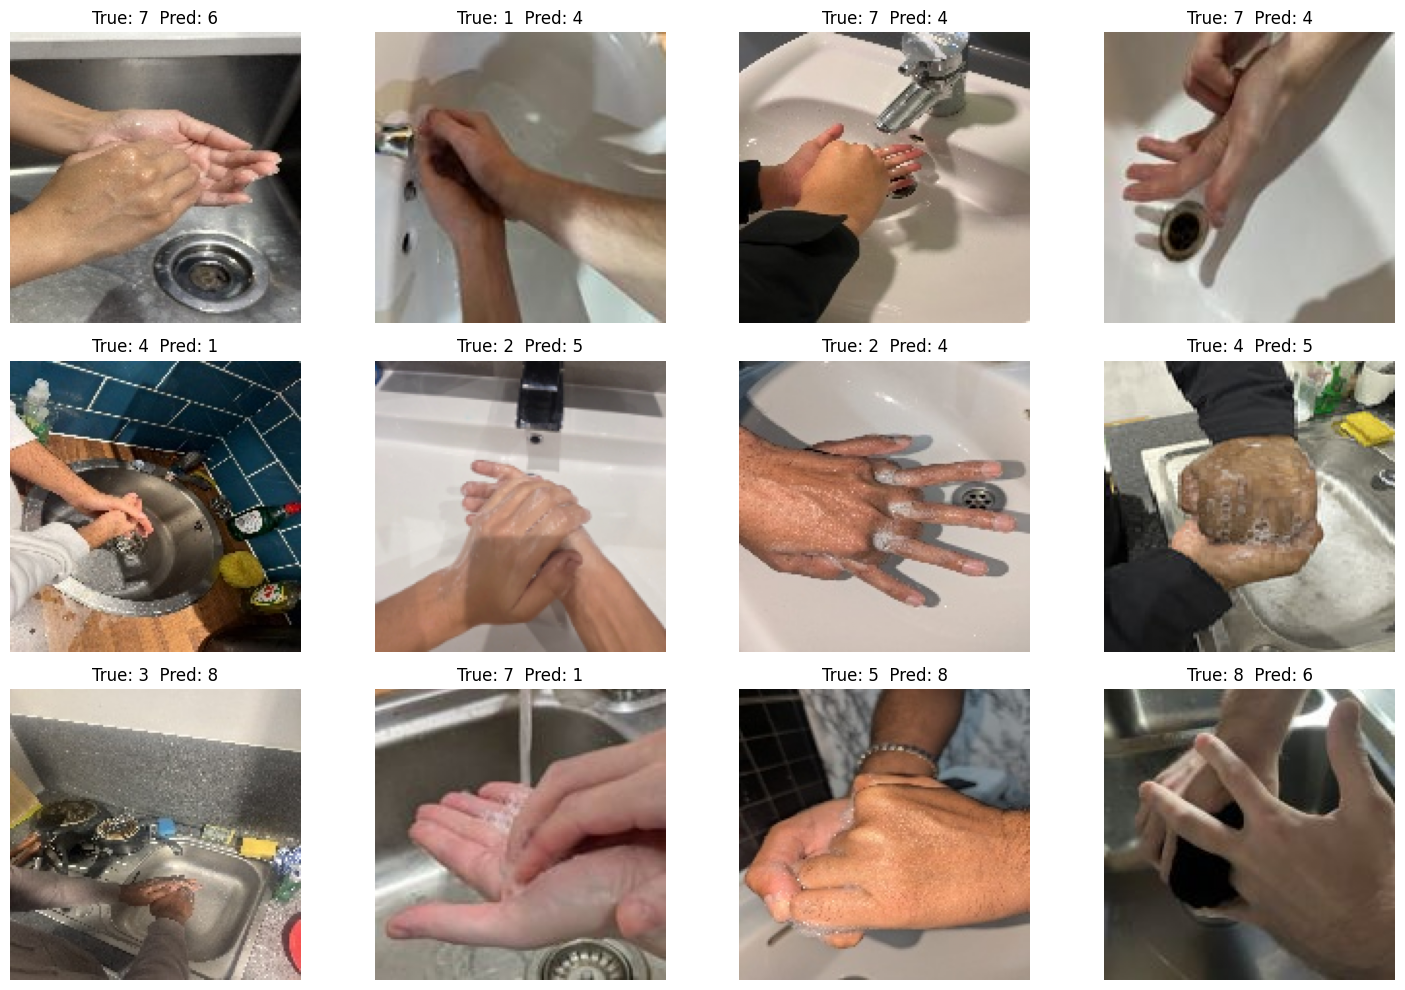

In [ ]:
# visualise label issues identified by cleanlab
def show_issues(indices, n=12):
    plt.figure(figsize=(15,10))
    for i, idx in enumerate(indices[:n]):
        plt.subplot(3,4,i+1)
        plt.imshow(X_all[idx])
        plt.axis('off')

        true_lbl = y_all[idx] + 1
        pred_lbl = np.argmax(pred_probs[idx]) + 1

        plt.title(f"True: {true_lbl}  Pred: {pred_lbl}")

    plt.tight_layout()
    plt.show()

show_issues(label_issues)

# Deleting the skewed images
X_clean = np.delete(X_all, label_issues, axis=0)
y_clean = np.delete(y_all, label_issues, axis=0)

print(f"Original size: {len(X_all)}")
print(f"New size: {len(X_clean)}")


In [ ]:
# count of each class after cleaning
class_counts = Counter(y_clean)

for cls in sorted(class_counts.keys()):
    print(f"Stage {cls+1}: {class_counts[cls]}")


Stage 1: 927
Stage 2: 603
Stage 3: 575
Stage 4: 739
Stage 5: 749
Stage 6: 768
Stage 7: 759
Stage 8: 865


## Label errors:


<ol>
  <li>The method used</li>
  For identifying label issues, I used Cleanlab’s self-confidence method. Cleanlab works by comparing the model’s predicted probabilities with the provided labels and highlighting the images the model is least confident about.

  I tried several different modelling approaches, from pretrained models to building one from scratch however the highest accuracy I could achieve was around 62%, This suggested that the main problem wasn’t the choice of model but the data itself, the low accuracy infers that there are many mislabled images which naturally lowers the models accuracy additionally many images were difficult to distinguish after viusaly confirming, even for a trained model. Because of this, instead of relying on Cleanlab to identify exact label mistakes, which requires a highly accurate model, I used it to detect ambiguous or unclear images. These are the samples the model consistently struggled with, and removing them helps improve overall data quality.

  <li>Explain what kind of errors you found in the dataset.</li>
  Upon reviewing the top 20 samples flagged with the lowest confidence scores, I observed two distinct categories of data noise:
  Genuine Mislabeling: A portion of the flagged images were clearly categorized incorrectly (e.g., a "Stage 2" gesture labeled as "Stage 5").
  High Ambiguity: A significant number of the flagged images were not necessarily incorrect but were of low quality. These included samples with bad lighting, motion blur, or obscured camera angles that made the hand gesture indistinguishable.

  Overall errors found were a mix of genuine mistakes and low quality data. By removing these specific samples, I cleaned up the dataset so the final model wouldn't get confused by trying to learn from bad or contradictory examples.
  
  <li>List the total number of images left in each class/stage after the label error handling</li>
</ol>

<br>

<ol>
  <li>Stage 1: <887></li>
  <li>Stage 2: <587></li>
  <li>Stage 3: <683></li>
  <li>Stage 4: <785></li>
  <li>Stage 5: <680></li>
  <li>Stage 6: <770></li>
  <li>Stage 7: <762></li>
  <li>Stage 8: <889></li>
</ol>

## 4. Pre-process the Dataset

## Data Preprocessing
For the preprocessing step, I decided to handle everything while loading the data rather than doing it later. I focused on two main things here: resizing the images so they are all the same shape and normalizing the pixel values to help the model learn better.
<li>Resizing: The original images were all different sizes, which a CNN can't handle. I set a target size of 150 $\times$ 150 pixels for everything. This seemed like a good balance—small enough to keep the training fast on my machine, but big enough to still see the hand gestures clearly.</li>
<li>Normalization: I normalized the image data by dividing the pixel arrays by 255.0. This scales the original pixel values down to a range of 0 to 1. This step is important because neural networks typically perform more effectively with smaller input values.</li>

## 5. Split the data
<br>

Split the data into training, validation and testing dataset using Startification, ensuring equal class distribution

Choose appropriate values of training, validation and testing datasets.

Display total number of images in each dataset split.

In [ ]:
# <<insert yout code here>>
X_train, X_temp, y_train, y_temp = train_test_split(
    X_clean, y_clean, test_size=0.30, random_state=42, stratify=y_clean
)

# Split 2: validation (15%) and test (15%) from the remaining 30%
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Training set:", X_train.shape[0])
print("Validation set:", X_val.shape[0])
print("Test set:", X_test.shape[0])

Training set: (4189, 150, 150, 3)
Validation set: (898, 150, 150, 3)
Test set: (898, 150, 150, 3)


## Splitting the data
For the data splitting i decided to choose a 70:15:15 split ratio. 
<li>Training (70%): I allocated the majority of images to the training set because deep learning models, particularly CNNs, require a large volume of data to learn robust feature representations.</li>

<li>Validation (15%) & Testing (15%): I split the remaining 30% equally. This ensures the validation set is large enough to effectively tune hyperparameters (like learning rate) without over-optimizing, while the test set remains large enough to provide a statistically significant final evaluation.</li>

## 6. Model Implementation

In [ ]:
# shows original images
plt.figure(figsize=(12,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(X_train[i])
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.suptitle("Original Images (Before Augmentation)")
plt.tight_layout()
plt.show()

# Data augmentation
train_aug = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.02,
    height_shift_range=0.02,
    zoom_range=0.05,
    horizontal_flip=True
)

In [ ]:
# shows augmented images
batch = next(train_aug.flow(X_train[:16], y_train[:16], batch_size=16, shuffle=False))

aug_images = batch[0]  
aug_labels = batch[1] 

plt.figure(figsize=(12,8))
for i in range(len(aug_images)):
    plt.subplot(4,4,i+1)
    plt.imshow(aug_images[i])
    plt.title(f"Label: {aug_labels[i]}")
    plt.axis('off')
plt.suptitle("Augmented samples (visual check)")
plt.tight_layout()
plt.show()

## Data augmentation
As I already handled the resizing (to 150x150) during the loading phase, the only direct transformation needed here was normalising the pixel values to a range of 0 to 1. This is a standard step that helps the neural network calculate weights more efficiently and converge faster. For the data split, I chose a ratio of 70% Training, 15% Validation, and 15% Testing. I used stratified sampling to ensure that the balance of the 8 handwashing stages remains consistent across all three sets, so the test results are reliable and not biased by uneven classes.

One major challenge I had to address here was the reduction in dataset size. Since I used Cleanlab to remove the ambiguous and noisy samples to improve quality, I lost over 2,000 images. To prevent the model from overfitting on this smaller dataset, I implemented Data Augmentation (rotating, flipping, and shifting) on the training set. This helps compensate for the data loss and forces the model to learn robust features, like the shape of the hands—rather than just memorising specific pixels. Data augmentation is only applied to the training data, the validation and testing data was kept the same. 

In [ ]:
# <<insert yout code here>>
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

number_of_classes = len(np.unique(y_clean))

# the baseline model
def baseline_model(num_classes):
    model = Sequential([
        # conv layer 1
        Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D((2, 2)),

        # conv layer 2
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        # conv layer 3
        Conv2D(64, (3, 3), activation='relu'),

        # fully connected layers
        Flatten(),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# This is the model that I will tweak to optimise the performance form the baseline
def optimised_model(num_classes):
    model = Sequential([
        # Conv block 1
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(150, 150, 3)),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        # Conv block 2
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        # Conv block 3
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        # Conv block 4
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        # Conv2D(512, (3, 3), padding='same', activation='relu'),
        # BatchNormalization(),
        # MaxPooling2D(2, 2),
        Flatten(),

        Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(0.5),

        # Dense(128, activation='relu'),
        # Dropout(0.3),

        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [ ]:
base_model = baseline_model(number_of_classes)
opt_model = optimised_model(number_of_classes)

In [ ]:
# training the base model
base_model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_val, y_val))
# Evaluate the model on test data
test_loss, test_acc = base_model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.2f}")

Epoch 1/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.1630 - loss: 2.0737 - val_accuracy: 0.1682 - val_loss: 2.0754
Epoch 2/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.2263 - loss: 2.0006 - val_accuracy: 0.2561 - val_loss: 1.9575
Epoch 3/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.3600 - loss: 1.7256 - val_accuracy: 0.3029 - val_loss: 1.9212
Epoch 4/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.6049 - loss: 1.0837 - val_accuracy: 0.3207 - val_loss: 2.5709
Epoch 5/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.8656 - loss: 0.4004 - val_accuracy: 0.3007 - val_loss: 3.6318
Epoch 6/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.9740 - loss: 0.1093 - val_accuracy: 0.3107 - val_loss: 5.3094
Epoch 7/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.9814 - loss: 0.0802 - val_accuracy: 0.3107 - val_loss: 6.3585
Epoch 8/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.9938 - loss: 0.0346 - 

In [ ]:
# training optimised model with augmentation
opt_model.fit(train_aug.flow(X_train, y_train, batch_size=32), epochs=30, validation_data=(X_val, y_val))
test_loss, test_acc = opt_model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.2f}")

Epoch 1/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 46s 336ms/step - accuracy: 0.1786 - loss: 2.8384 - val_accuracy: 0.1548 - val_loss: 4.8190
Epoch 2/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 43s 329ms/step - accuracy: 0.2170 - loss: 2.5147 - val_accuracy: 0.1626 - val_loss: 4.6670
Epoch 3/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 44s 336ms/step - accuracy: 0.2361 - loss: 2.4784 - val_accuracy: 0.2038 - val_loss: 3.3030
Epoch 4/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 43s 330ms/step - accuracy: 0.2767 - loss: 2.3982 - val_accuracy: 0.2829 - val_loss: 2.4516
Epoch 5/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 43s 324ms/step - accuracy: 0.2905 - loss: 2.3539 - val_accuracy: 0.3129 - val_loss: 2.3409
Epoch 6/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 43s 324ms/step - accuracy: 0.3187 - loss: 2.2936 - val_accuracy: 0.3352 - val_loss: 2.2531
Epoch 7/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 43s 325ms/step - accuracy: 0.3371 - loss: 2.2181 - val_accuracy: 0.3107 - val_loss: 2.3628
Epoch 8/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 43s 326ms/step - accuracy: 0.3664 - loss: 2

In [ ]:
# converting data back to original scale for efficientnetb0
X_train_eff = X_train * 255.0
X_val_eff = X_val * 255.0
X_test_eff = X_test * 255.0

In [ ]:
# Tranfer Learning with EfficientNetB0
def TransferLearningModel(num_classes, unfreeze_depth):
    base_model = tf.keras.applications.EfficientNetB0(input_shape=(150, 150, 3), 
                                                      include_top=False, 
                                                      weights='imagenet')
    
    # unfreezes the last 30 layers so they can learn
    base_model.trainable = True
    if unfreeze_depth != 'all':
        for layer in base_model.layers[:-unfreeze_depth]:
            layer.trainable = False
    
    # head of the model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Block 1
    x = Dense(256, use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    # 2. Batch Norm (Clean the data)
    x = BatchNormalization()(x)
    # 3. Activation (Now apply ReLU)
    x = Activation('relu')(x)
    # 4. Dropout (Safety)
    x = Dropout(0.5)(x)

    # Block 2
    x = Dense(256, use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=outputs)
    
    # compile the model
    model.compile(optimizer=Adam(1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

eff_model = TransferLearningModel(number_of_classes, 70)

total_params = eff_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in eff_model.trainable_weights])
non_trainable_params = total_params - trainable_params

print(f"Total Parameters:     {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Frozen Parameters:    {non_trainable_params:,}")


Total Parameters:     4,446,891
Trainable Parameters: 3,458,628
Frozen Parameters:    988,263


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=2, 
    min_lr=1e-7, 
    verbose=1
)

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True, 
    verbose=1
)


# Training the transfer learning model
history = eff_model.fit(train_aug.flow(X_train_eff, y_train, batch_size=16), 
                        epochs=30, 
                        validation_data=(X_val_eff, y_val),
                        callbacks=[lr_scheduler, early_stopping])

test_loss, test_acc = eff_model.evaluate(X_test_eff, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.2f}") 

Epoch 1/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 46s 134ms/step - accuracy: 0.1829 - loss: 3.1462 - val_accuracy: 0.4543 - val_loss: 2.2975 - learning_rate: 1.0000e-04
Epoch 2/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 33s 124ms/step - accuracy: 0.3471 - loss: 2.5388 - val_accuracy: 0.6013 - val_loss: 1.8774 - learning_rate: 1.0000e-04
Epoch 3/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 33s 126ms/step - accuracy: 0.4631 - loss: 2.1838 - val_accuracy: 0.6715 - val_loss: 1.6752 - learning_rate: 1.0000e-04
Epoch 4/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 33s 124ms/step - accuracy: 0.5756 - loss: 1.8834 - val_accuracy: 0.7105 - val_loss: 1.5537 - learning_rate: 1.0000e-04
Epoch 5/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 32s 123ms/step - accuracy: 0.6276 - loss: 1.7404 - val_accuracy: 0.7472 - val_loss: 1.4460 - learning_rate: 1.0000e-04
Epoch 6/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 32s 123ms/step - accuracy: 0.6722 - loss: 1.6021 - val_accuracy: 0.7728 - val_loss: 1.3740 - learning_rate: 1.0000e-04
Epoch 7/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 32s 12

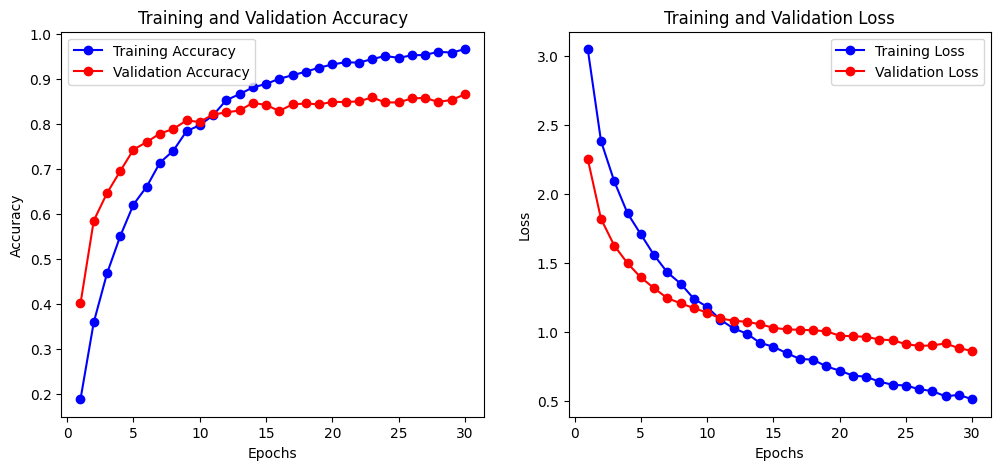

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy') # 'bo-' = Blue dots with line
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy') # 'ro-' = Red dots with line
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 4. Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 7. Evaluate the Model

In [ ]:
# <<insert yout code here>>

### Training Curves

In [ ]:
# <<insert yout code here>>

### Make Inference
For some unseen data, make predictions using the trained model.

In [ ]:
# <<insert yout code here>>